### Importing relevant libraries

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Importing dataset

In [3]:
df = pd.read_csv("alldata.csv")

In [4]:
df = df.drop("Unnamed: 7", axis = 1)

In [5]:
df = df.drop(1042, axis = 0)

In [6]:
df["ZeroCross"] = df["ZERO CROSS OVER"].copy()
df = df.drop("ZERO CROSS OVER", axis =1)
df["SignalCross"] = df["SIGNAL LINE CROSSOVER"].copy()
df = df.drop("SIGNAL LINE CROSSOVER", axis = 1)
df["macdDecision"] = df["Decision"].copy()
df = df.drop("Decision", axis = 1)

### Transforming hammer variable: 0= no hammer, 1 = hammer

In [7]:
df["Hammer"] = df["Hammer"].replace("HAMMER", 1)
df["Hammer"] = df["Hammer"].fillna(0)

### Transforming Support and Resistance: support = resistance = 1 ; other = 0

In [8]:
def supportResistanceEncoding(df):
    df["Support"] = df["Support"].fillna(0)
    df["Resistance"] = df["Resistance"].fillna(0)
    df.loc[df.Support == "S", "Support"] = 1
    df.loc[df.Resistance == "R", "Resistance"] = 1

supportResistanceEncoding(df)


### Transforming Zero cross over and signal Line Crossover: sell = 0, buy = 1

In [9]:
def crossoverEncoding(df):
    df.loc[df.ZeroCross == "Buy", "ZeroCross"] = 1
    df.loc[df.SignalCross == "Buy", "SignalCross"] = 1
    df.loc[df.ZeroCross == "Sell", "ZeroCross"] = 0
    df.loc[df.SignalCross == "Sell", "SignalCross"] = 0
    
crossoverEncoding(df)

In [10]:
#dropping this column since it is not common practice to base a decision only on the two crossovers
df = df.drop("macdDecision", axis = 1)

### Finding perfect buy/sell/hold entries 
#### looking at future values, we will determine if at each entry, the best option would have been to buy/sell/hold based on the return on the investment (%)

In [1]:
# Assume zero trading cost
# 0 = hold, 1 = buy, 2 = sell
# Rule: compare today's closing and +timeframe day's closing
# We omit the first 26 days since williams%Rs are unavailable, decision value = -1
# We omit the last timeframe days since the next timeframe days closing is unavailable, decision value = -1

def perfectEntries_2(df, timeframe):
    decision = [-1 for i in range(33)]  # for the first 32 days
    currentdecision = 0

    for i in range(33, (len(df) - timeframe)):  # from 33th day to the timeframe days before the last day
        if df.iloc[i+timeframe]['Close'] > df.iloc[i]['Close']:
            if currentdecision != 1:
                currentdecision = 1
            else:
                currentdecision = 0
            decision.append(currentdecision)
            currentdecision = 1  # Make sure if next day is buy, we show it hold
        elif df.iloc[i+timeframe]['Close'] < df.iloc[i]['Close']:
            # The first sell cannot appear before buy or hold
            if decision.count(1) > 0:
                if currentdecision != 2:
                    currentdecision = 2
                else:
                    currentdecision = 0
                decision.append(currentdecision)
                currentdecision = 2  # Make sure if next day is sell, we show it hold
            else:
                currentdecision = 0
                decision.append(currentdecision)
        else:
            currentdecision = 0
            decision.append(currentdecision)
    for i in range(timeframe):
        decision.append(-1)  # for the last timeframe days

    return decision


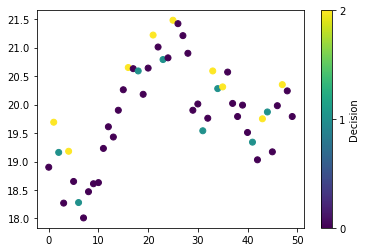

In [12]:
df['Decision'] = perfectEntries_2(df,2)
plt.scatter(range(50), df["Close"][500:550], c=df["Decision"][500:550])
plt.colorbar(ticks = range(3), label='Decision')
# looking at two days in advance seems like the better solution, 1 sometimes miss opportunities and higher(7 and 14 were tried) 
# and it gives weird signals 

In [13]:
# Convert willianR values to 0 = neutral, 1 = overbought, 2 = oversold
# The first 13 days are excluded, gives zero value automatically

def williamsREncoding(df):

    williamsR = [0 for i in range(13)]

    for i in range(13, len(df)):

        if df.iloc[i]['WilliamR'] < -0.2 and df.iloc[i]['WilliamR'] > -0.8:
            williamsR.append(0)
        elif df.iloc[i]['WilliamR'] >= -0.2:
            williamsR.append(1)
        else:
            williamsR.append(2)
    
    return williamsR

df.insert(11, 'Williams%R', williamsREncoding(df))


In [14]:
# df.to_csv('cleaned_data.csv')